## VGG in PyTorch

In Google Colab we have access to a Tesla T4. This will allow us to train a VGG16 network with a relatively small batch size of 32. The original implementation had 256 samples per batch, but will still be able to train our models effectively.

In [1]:
!nvidia-smi

Wed Aug 17 10:44:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

import os
import pathlib
import zipfile
import shutil

### Data Preparation

We will keep using the cats vs dogs dataset, so the firt part of the notebook should be familiar. We download the data from kaggle, prepare the necessary folders and create the training, validation and the test datasets.

In [3]:
!mkdir ~/.kaggle

In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -p /content/datasets  -c dogs-vs-cats

 97% 786M/812M [00:03<00:00, 206MB/s]
100% 812M/812M [00:03<00:00, 216MB/s]


In [7]:
root = pathlib.Path('/content/datasets')

In [8]:
if not os.path.exists(root / 'dogs-vs-cats'):
  with zipfile.ZipFile(root / 'dogs-vs-cats.zip', 'r') as zip_ref:
      zip_ref.extractall(root / 'dogs-vs-cats')
      
  with zipfile.ZipFile(root / 'dogs-vs-cats/train.zip', 'r') as zip_ref:
      zip_ref.extractall(root / 'dogs-vs-cats')


In [9]:
original_path = root / 'dogs-vs-cats'
new_path = root / 'dogs_vs_cats_prepared'

In [10]:
# prepare list of files
file_names = os.listdir(original_path / 'train')
test_file_names = file_names[0:5000]
val_file_names = file_names[5000:10000]
train_file_names = file_names[10000:]

In [11]:
# prepare dirs
for directory in ["train", "test", "val"]:
    for category in ["cat", "dog"]:
        new_dir = new_path / directory / category
        if os.path.exists(new_dir):
            shutil.rmtree(new_dir)
        os.makedirs(new_dir)

In [12]:
def copy_files(old_dir, new_dir, files_list):
    for idx, filename in enumerate(files_list):
        src = old_dir / filename
        if filename.startswith('cat'):
            dst = new_dir / 'cat' / filename
        elif filename.startswith('dog'):
            dst = new_dir / 'dog' / filename
        else:
            continue
            
        shutil.copyfile(src=src, dst=dst)

In [13]:
copy_files(old_dir=original_path / "train", new_dir=new_path / 'train', files_list=train_file_names)
copy_files(old_dir=original_path / "train", new_dir=new_path / 'val', files_list=val_file_names)
copy_files(old_dir=original_path / "train", new_dir=new_path / 'test', files_list=test_file_names)

In [14]:
root = new_path

In [15]:
train_transform = T.Compose([T.Resize((256, 256)), 
                             T.RandomCrop(size=(224, 224)),
                             T.ToTensor()])

test_transform = T.Compose([T.Resize((224, 224)), 
                                T.ToTensor()])

In [16]:
train_dataset = ImageFolder(root=root / 'train', transform=train_transform)
val_dataset = ImageFolder(root=root / 'val', transform=test_transform)
test_dataset = ImageFolder(root=root / 'test', transform=test_transform)

In the original paper a batch size of 256 was used. We use a batch size of 32 in order to be able to fit the data on the memory of the graphics card.

In [17]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=32

In [18]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

### Model Creation and Training

VGG has a lot of repeatable blocks. It is common practice, when implementing VGG is to store the configuration in a list and to construct the model from the config. The numbers below mean that we are dealing with a convolutional layer with a particular amount of filters. 'M' on the other hand indicates a maxpool layer. 

In [19]:
cfg = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"]

We create a VGG block from a PyTorch module. The block applies a convolutional operation, a batch norm and a ReLU activation. We are going to reuse the module many times.  

In [20]:
class VGG_Block(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.layer = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(num_features=out_channels),
      nn.ReLU(inplace=True)
    )
  
  def forward(self, x):
    return self.layer(x)


The final model once again consists of a feature extractor and a classifier. The feature extractor is built from the configuration file defined below using the `_make_feature_extractor` method. The method loops over the config and creates modules based on the paramers in the config list. At the end the modules are packed into a `Sequential` module.

Additionally we use the `AdaptiveAvgPool2d` layer. This is a common procedure if you know how the dimensions of the network should look like, but you do not want to calculate the kernel size, stride by hand. When we use `nn.AdaptiveAvgPool2d((7, 7))` we essentiall ask PyTorch to return back feature maps of size 7x7. 

In [21]:
class Model(nn.Module):

    def __init__(self, cfg, num_classes=1):
        super().__init__()
        self.cfg = cfg
        self.feature_extractor = self._make_feature_extractor()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1)
        )
        
    def _make_feature_extractor(self):
        layers = []
        in_channels = 3
        for element in self.cfg:
            if element == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [VGG_Block(in_channels, element)]
                in_channels = element
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [22]:
def track_performance(dataloader, model, criterion):
    # switch to evaluation mode
    model.eval()
    num_samples = 0
    num_correct = 0
    loss_sum = 0
    
    # no need to calculate gradients
    with torch.inference_mode():
        for batch_idx, (features, labels) in enumerate(dataloader):
            features = features.to(DEVICE)
            labels = labels.to(DEVICE).view(-1, 1).float()
            logits = model(features)
            probs = torch.sigmoid(logits)
                        
            predictions = (probs > 0.5).float()
            num_correct += (predictions == labels).sum().item()
            
            loss = criterion(logits, labels)
            loss_sum += loss.cpu().item()
            num_samples += len(features)
    
    # we return the average loss and the accuracy
    return loss_sum/num_samples, num_correct/num_samples

In [23]:
def plot_history(history):
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy")
    plt.legend()
    
    fig.add_subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()


In [24]:
def train(num_epochs, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler=None):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    model.to(DEVICE)
    for epoch in range(num_epochs):
        for batch_idx, (features, labels) in enumerate(train_dataloader):
            model.train()
            features = features.to(DEVICE)
            labels = labels = labels.to(DEVICE).view(-1, 1).float()
            
            # Empty the gradients
            optimizer.zero_grad()
            
            # Forward Pass
            logits = model(features)
            
            # Calculate Loss
            loss = criterion(logits, labels)
            
            # Backward Pass
            loss.backward()
            
            # Gradient Descent
            optimizer.step()
            
        train_loss, train_acc = track_performance(train_dataloader, model, criterion)
        val_loss, val_acc = track_performance(val_dataloader, model, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f'Epoch: {epoch+1:>2}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}')
        
        if scheduler:
          scheduler.step(val_loss)
    return history          


In [35]:
model = Model(cfg)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       patience=2,
                                                       verbose=True)
criterion = nn.BCEWithLogitsLoss()

You will notice that we achieve a much higher accuracy with this model, but as mentioned before the model is quite large, so even 10 epochs will take roughly an hour to finish. 

In [36]:
history = train(10, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler)

Epoch:  1/10 | Train Loss: 0.01985 | Val Loss: 0.02015 | Train Acc: 0.654 | Val Acc: 0.643
Epoch:  2/10 | Train Loss: 0.01987 | Val Loss: 0.02033 | Train Acc: 0.643 | Val Acc: 0.641
Epoch:  3/10 | Train Loss: 0.01530 | Val Loss: 0.01569 | Train Acc: 0.771 | Val Acc: 0.772
Epoch:  4/10 | Train Loss: 0.01158 | Val Loss: 0.01220 | Train Acc: 0.837 | Val Acc: 0.825
Epoch:  5/10 | Train Loss: 0.00818 | Val Loss: 0.00891 | Train Acc: 0.887 | Val Acc: 0.874
Epoch 00005: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  6/10 | Train Loss: 0.00473 | Val Loss: 0.00595 | Train Acc: 0.941 | Val Acc: 0.921
Epoch:  7/10 | Train Loss: 0.00418 | Val Loss: 0.00561 | Train Acc: 0.948 | Val Acc: 0.925
Epoch:  8/10 | Train Loss: 0.00392 | Val Loss: 0.00540 | Train Acc: 0.950 | Val Acc: 0.929
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  9/10 | Train Loss: 0.00341 | Val Loss: 0.00509 | Train Acc: 0.959 | Val Acc: 0.935
Epoch: 10/10 | Train Loss: 0.00325 | Val Loss: 0.00505 | 

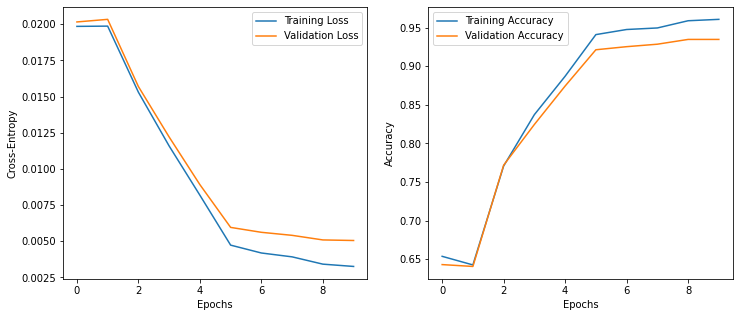

In [37]:
plot_history(history)

### Transfer Learning

It turns out that transfer learning with pretrained VGG weights, allows us to achieve a classification accuracy close to 99%.

In [46]:
from torchvision.models import vgg19_bn, VGG19_BN_Weights

In [47]:
model = vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1, progress=False)

In [48]:
for param in model.parameters():
    param.requires_grad = False

In [49]:
model.classifier[0].requires_grad = True
model.classifier[3].requires_grad = True

In [50]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=1)

In [51]:
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       patience=2,
                                                       verbose=True)
criterion = nn.BCEWithLogitsLoss()

In [52]:
history = train(10, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler)

Epoch:  1/10 | Train Loss: 0.00102 | Val Loss: 0.00109 | Train Acc: 0.988 | Val Acc: 0.989
Epoch:  2/10 | Train Loss: 0.00108 | Val Loss: 0.00119 | Train Acc: 0.986 | Val Acc: 0.986
Epoch:  3/10 | Train Loss: 0.00089 | Val Loss: 0.00095 | Train Acc: 0.989 | Val Acc: 0.987
Epoch:  4/10 | Train Loss: 0.00111 | Val Loss: 0.00141 | Train Acc: 0.988 | Val Acc: 0.984
Epoch:  5/10 | Train Loss: 0.00071 | Val Loss: 0.00093 | Train Acc: 0.991 | Val Acc: 0.988
Epoch:  6/10 | Train Loss: 0.00076 | Val Loss: 0.00101 | Train Acc: 0.991 | Val Acc: 0.988
Epoch:  7/10 | Train Loss: 0.00072 | Val Loss: 0.00093 | Train Acc: 0.992 | Val Acc: 0.989
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  8/10 | Train Loss: 0.00066 | Val Loss: 0.00088 | Train Acc: 0.992 | Val Acc: 0.989
Epoch:  9/10 | Train Loss: 0.00071 | Val Loss: 0.00091 | Train Acc: 0.991 | Val Acc: 0.990
Epoch: 10/10 | Train Loss: 0.00070 | Val Loss: 0.00089 | Train Acc: 0.991 | Val Acc: 0.990
Epoch 00010: reducing learni

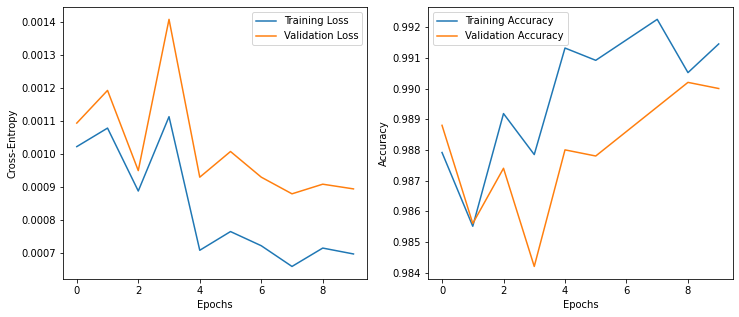

In [53]:
plot_history(history)